## Supervised Learning: Challenge

In this challenge, we will try to predict credit card fraud.

Download the data from [here](https://drive.google.com/file/d/1FCQY1SiWIjh_ME6Wtb3FG8Y1sKoRwAUc/view?usp=sharing). The data is originally from a [Kaggle Competition](https://www.kaggle.com/mlg-ulb/creditcardfraud).

The dataset contains transactions made by credit cards within two days in September 2013 by European cardholders.  Where **we have 492 occurrences of fraud out of the total of 284,807 transactions**. This dataset is highly unbalanced, with the positive class (frauds) account for 0.172% of all transactions.

____________________
### **Challenge:** Identify fraudulent credit card transactions.

Features V1, V2, … V28 are the principal components obtained with PCA. The only features that are not transformed with PCA are `'Time'` and `'Amount'`.  

- The feature `'Time'` contains the seconds elapsed between each transaction and the first transaction in the dataset.
- The feature `'Amount'` is the transaction amount; this feature can be used for example-dependant cost-sensitive learning. 
- The feature `'Class'` is the target variable, and it takes the value of 1 in case of fraud and 0 otherwise.

> #### Warning
> There is a huge class imbalance ratio, so we need to be careful when evaluating. It might be better to use the method `.predict_proba()` with a custom cut-off to search for fraudulent transactions.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform

from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import pickle

In [40]:
df = pd.read_csv('creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


### *Exploratory Data Analysis*

(array([10510., 16955., 38526., 38550., 40243., 10145., 17161., 38951.,
        40779., 32987.]),
 array([     0. ,  17279.2,  34558.4,  51837.6,  69116.8,  86396. ,
        103675.2, 120954.4, 138233.6, 155512.8, 172792. ]),
 <BarContainer object of 10 artists>)

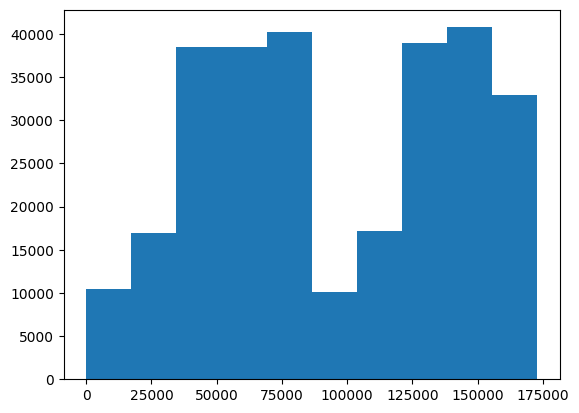

In [8]:
plt.hist(df['Time'])

In [21]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [42]:
# Because class 1 is fraud, the sum of 'Class' should give total number of fraud cases.
fraud_count = df['Class'].sum()
fraud_rate = fraud_count/len(df)
print(f'Total fraud count: {fraud_count}\tTotal rows: {len(df)}\tFraud rate: {fraud_rate}')

Total fraud count: 492	Total rows: 284807	Fraud rate: 0.001727485630620034


In [26]:
# Look at the range of the feature data to see if it should be transformed
pd.DataFrame(df.describe().loc['max',:] - df.describe().loc['min',:]).transpose()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,172792.0,58.86244,94.773457,57.708148,22.558515,148.544973,99.462131,164.146736,93.223927,29.029061,...,62.033221,21.436234,67.336147,7.421176,17.814986,6.121896,54.177877,49.277892,25691.16,1.0


### *Preparation*

* Split the data
* Grid or random search
* Print model evalutation metrics: 
    * recall
    * precision
    * F1
    * AUC score
* Plot:
    * confusion matrix
    * ROC
* Try different models
    * Logistic regression
    * Naïve Bayes
    * SVM (linear, rbf, poly)
    * Random forest
    * Gradient boost
    * XGBoost

In [36]:
X = df[df.columns[:-1]]
X.head(1)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62


In [45]:
uniform(loc=0, scale=4)

In [31]:
# # Define a function
# def supervised(estimator, df, param_distributions, model_name='model'):
#     """
#     * Split the data
#     * Scale the data
#     * Perform the following for both raw and scaled data:
#         * Random search to find best parameters
#         * Print model evalutation metrics: 
#             * recall
#             * precision
#             * F1
#             * AUC score
#         * Plot:
#             * confusion matrix
#             * ROC
#     Params:
#     * df: Dataframe with all data and target variable as last column.
    
#     Returns:
#     * Best model from random search
#     """
#     X = df[df.columns[:-1]]
#     y = df[df.columns[-1]]
#     X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state=0)

#     scaler = MinMaxScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)

#     search = RandomizedSearchCV(estimator, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)
#     best_model = search.best_estimator_

#     y_pred = best_model.predict(X_test)
#     y_pred_train = best_model.predict(X_train)
#     MSE = mean_squared_error(y_test, y_pred)
#     r2_train = r2_score(y_train, y_pred_train)
#     r2 = r2_score(y_test, y_pred)
#     print(f'Model: {model_name}\tMeansquared error: {MSE}\tR^2 on test data: {r2}')
#     print(f'\tR^2 score from training data: {r2_train}\tDifference between training vs. test R^2 scores: {r2_train-r2}')
#     print(f'Best model parameters from grid search: {grid.best_params_}')
#     return best_model

{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x1fc52a05e50>,
 'penalty': ['l2', 'l1']}

In [51]:
# List parameters common for several methods
C_list = uniform(loc=0, scale=4)
max_iter_list = np.arange(100,500,100)
max_iter_list

array([100, 200, 300, 400])

In [96]:
# Define a class
class supervised:
    """
    * Split the data
    * Scale the data
    * Perform the following for both raw and scaled data:
        * Random search to find best parameters
        * Print model evalutation metrics: 
            * recall
            * precision
            * F1
            * AUC score
        * Plot:
            * confusion matrix
            * ROC
    Params:
    * df: Dataframe with all data and target variable as last column.
    
    Returns:
    * Best model from random search
    """
    def __init__(self, df, estimator, param_distributions, model_name):
        X = df[df.columns[:-1]]
        y = df[df.columns[-1]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state=0)
        self.X_train_pre = X_train
        self.X_test_pre =  X_test
        self.y_train = y_train
        self.y_test =  y_test
        self.estimator = estimator
        self.params = param_distributions
        self.model_name = model_name

    def get_best_model(self,scaled=True):
        if scaled==True:
            scaler = MinMaxScaler()
            self.X_train = scaler.fit_transform(self.X_train_pre)
            self.X_test = scaler.transform(self.X_test_pre)
            print('**Data has been scaled.**')
        else:
            self.X_train = self.X_train_pre
            self.X_test = self.X_test_pre
            print('**Data not scaled**')
        search = RandomizedSearchCV(self.estimator, param_distributions=self.params, random_state=0,n_jobs=-2)
        search.fit(self.X_train, self.y_train)
        best_model = search.best_estimator_

        y_pred = best_model.predict(self.X_test)
        y_pred_train = best_model.predict(self.X_train)

        # test_set = (self.y_test, y_pred)
        # train_set = (self.y_train, y_pred_train)

        # Metrics for test data
        recall = recall_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        f1score = f1_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_pred)

        # Metrics for training data
        recall_train = recall_score(self.y_train, y_pred_train)
        precision_train = precision_score(self.y_train, y_pred_train)
        f1score_train = f1_score(self.y_train, y_pred_train)
        auc_train = roc_auc_score(self.y_train, y_pred_train)

        print(f'\n{self.model_name} evaluation metrics: \n\tTest data\tTraining data\t\tDifference')
        print(f'Recall: \t{100*recall:.2f}%\t\t{100*recall_train:.2f}%\t\t{100*(recall-recall_train):.2f}%')
        print(f'Precision: \t{100*precision:.2f}%\t\t{100*precision_train:.2f}%\t\t{100*(precision-precision_train):.2f}%')
        print(f'F1: \t\t{100*f1score:.2f}%\t\t{100*f1score_train:.2f}%\t\t{100*(f1score-f1score_train):.2f}%')
        print(f'AUC: \t\t{100*auc:.2f}%\t\t{100*auc_train:.2f}%\t\t{100*(auc-auc_train):.2f}%')
        
        print(f'Best model parameters from randomized search: {search.best_params_}')
        ConfusionMatrixDisplay.from_estimator(best_model, self.X_test, self.y_test)
        RocCurveDisplay.from_estimator(best_model, self.X_test, self.y_test)
        return best_model


### *Logistical regression*

**Data has been scaled.**

logistical regression evaluation metrics: 
	Test data	Training data		Difference
Recall: 	59.41%		57.80%		1.61%
Precision: 	88.24%		88.28%		-0.05%
F1: 		71.01%		69.86%		1.15%
AUC: 		79.70%		78.89%		0.80%
Best model parameters from randomized search: {'C': 3.854651042004117, 'class_weight': None, 'max_iter': 200}


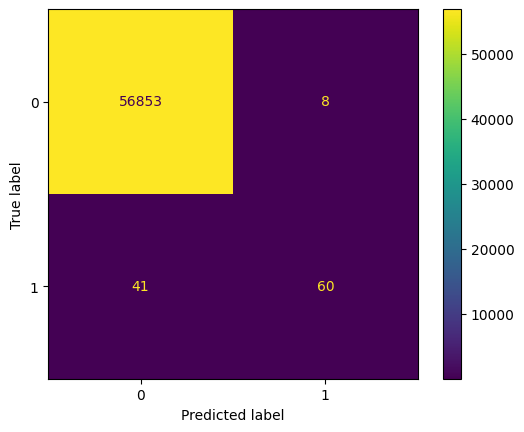

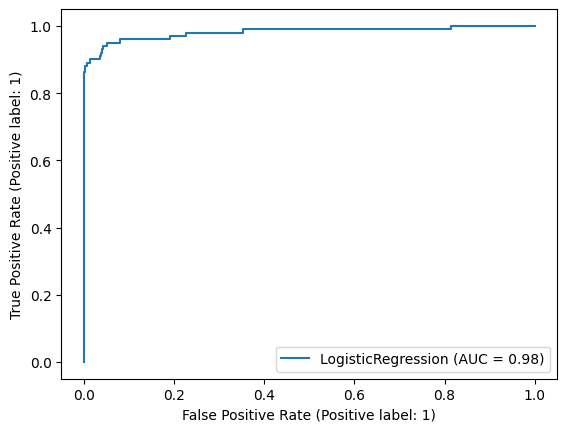

In [106]:

# Logistical regression
param_lr = {
    # 'penalty': ['l1','l2', 'elasticnet'],
    'C': C_list,
    'max_iter' : max_iter_list,
    'class_weight': [None, 'balanced']
}

lr = LogisticRegression(random_state=0)
lr_attributes = supervised(df, lr, param_lr, model_name='logistical regression')
best_lr = lr_attributes.get_best_model()

# Save the model
model = best_lr

filename = 'model_best_lr.sav'
pickle.dump(model, open(filename, 'wb'))

### *Gaussian Naïve Bayes*

**Data has been scaled.**

Gaussian Naïve Bayes evaluation metrics: 
	Test data	Training data		Difference
Recall: 	85.15%		82.35%		2.80%
Precision: 	6.60%		6.00%		0.60%
F1: 		12.25%		11.19%		1.06%
AUC: 		91.50%		90.07%		1.44%
Best model parameters from randomized search: {'var_smoothing': 9.636627605010293e-06}


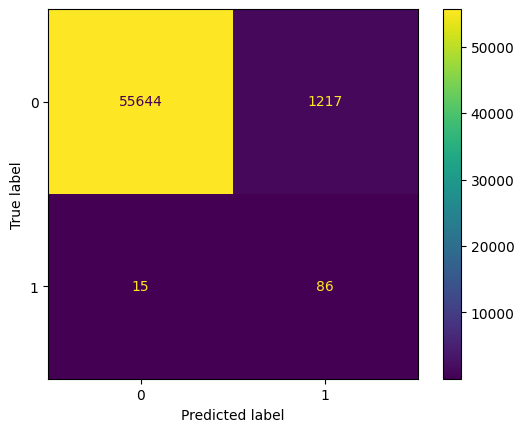

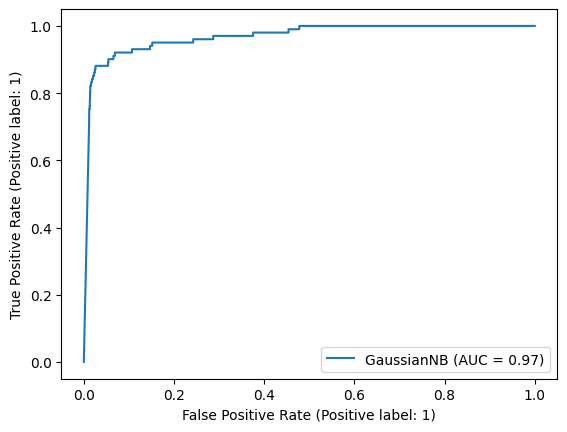

In [105]:
# Naïve Bayes
param_nb = {
    'var_smoothing': uniform(loc=0, scale=1e-05)
}

nb = GaussianNB()
nb_attributes = supervised(df, nb, param_nb, model_name='Gaussian Naïve Bayes')
best_nb = nb_attributes.get_best_model()

12.152777777777779

### *SVM*

**Data has been scaled.**


C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVC rbf evaluation metrics: 
	Test data	Training data		Difference
Recall: 	82.18%		79.28%		2.89%
Precision: 	85.57%	87.32%		-1.76%
F1: 		83.84%		83.11%		0.73%
AUC: 		91.08%		89.63%		1.44%
Best model parameters from randomized search: {'C': 3.8286206358121855, 'class_weight': None, 'degree': 2, 'gamma': 'scale', 'max_iter': 400, 'probability': True, 'random_state': 0}


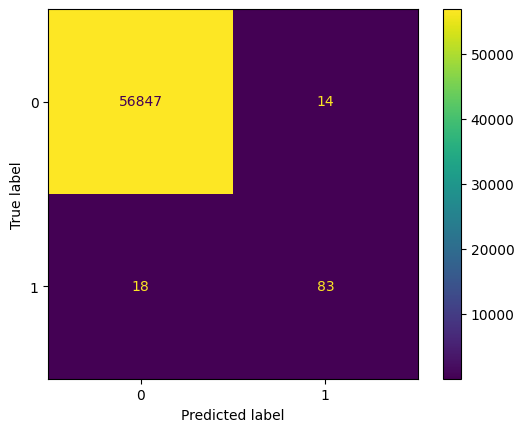

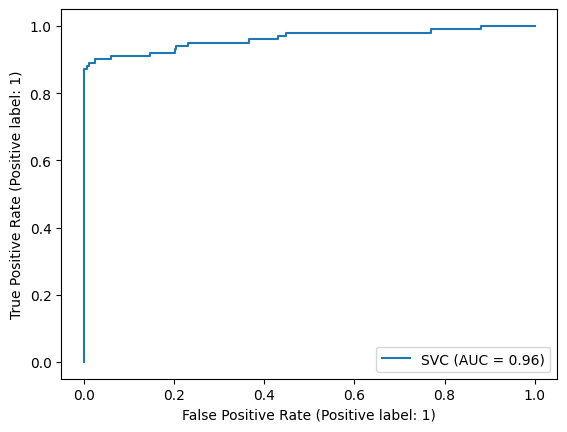

In [92]:
model_name = 'SVC rbf'

params = {
    'C': C_list,
    'degree': np.arange(2,8),
    'gamma': ['scale','auto'],
    'probability': [True, False],
    'class_weight': ['balanced', None],
    'max_iter': max_iter_list,
    'random_state': [0]
}

model = SVC(kernel='rbf')
model_attributes = supervised(df, model, params, model_name=model_name)

best_svm_rbf = model_attributes.get_best_model()

In [93]:
best_svm_rbf

SVC(C=3.8286206358121855, degree=2, max_iter=400, probability=True,
    random_state=0)

In [94]:
# save the model to disk

model = best_svm_rbf

filename = 'model_best_svm_rbf.sav'
pickle.dump(model, open(filename, 'wb'))


In [95]:
# Load the saved model
pickle.load(open(filename, 'rb'))

SVC(C=3.8286206358121855, degree=2, max_iter=400, probability=True,
    random_state=0)

In [90]:
# Check to see if data was scaled above
pd.DataFrame(model_attributes.X_train, columns=X.columns).describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.548823,0.950332,0.741710,0.782089,0.251980,0.552757,0.495537,0.497158,0.785371,0.462779,...,0.374972,0.561484,0.510045,0.665430,0.412439,0.577917,0.429145,0.649953,0.341114,0.004509
std,0.274901,0.039655,0.019316,0.035182,0.062786,0.017915,0.027975,0.013986,0.012931,0.037892,...,0.012128,0.011890,0.033901,0.009253,0.088418,0.029236,0.079426,0.011562,0.009343,0.012619
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.313684,0.931616,0.734706,0.761353,0.214365,0.543683,0.479336,0.490844,0.783142,0.440578,...,0.371590,0.557793,0.484691,0.663031,0.360604,0.560133,0.375244,0.647931,0.339578,0.000289
50%,0.490399,0.950717,0.742469,0.786236,0.251153,0.552051,0.489761,0.497619,0.785617,0.461045,...,0.373954,0.561012,0.510356,0.665272,0.418352,0.578885,0.420599,0.650001,0.341443,0.001119
75%,0.806386,0.976981,0.751117,0.805949,0.284932,0.560782,0.503937,0.503668,0.788881,0.483373,...,0.377059,0.564496,0.534749,0.667626,0.476602,0.597595,0.468933,0.652577,0.343394,0.003948
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Data not scaled**


C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVC rbf evaluation metrics: 
		Test data		Training data		Difference
	Recall: 	2.97%		100.00%		-97.03%
	Precision: 	50.00%	100.00%		-50.00%
	F1: 	5.61%		100.00%		-94.39%
	AUC: 	51.48%		100.00%		-48.52%
Best model parameters from grid search: {'C': 2.195254015709299, 'class_weight': None, 'degree': 2, 'gamma': 'auto', 'max_iter': 400, 'probability': False, 'random_state': 0}


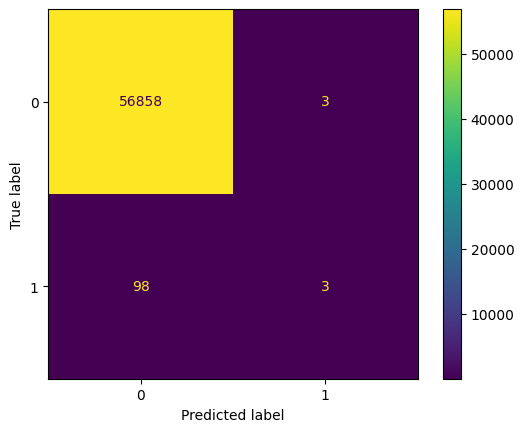

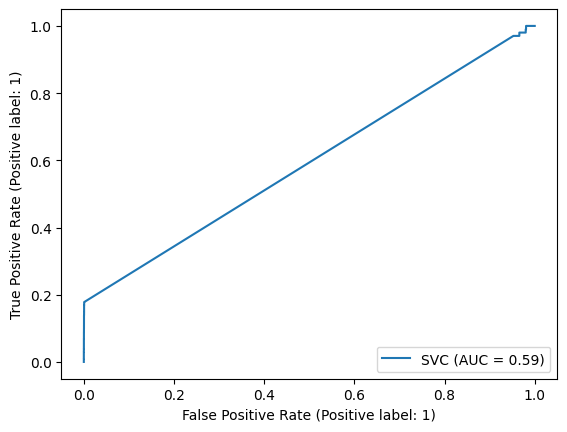

In [86]:
# Repeat without scaling; poor performance
best_svm_rbf = model_attributes.get_best_model(scaled=False)

In [ ]:
#Setting the range for class weights weights = np.linspace(0.0,0.99,200)  #Creating a dictionary grid for grid search 
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

**Data has been scaled.**


C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVC rbf with balanced class_weight evaluation metrics: 
	Test data	Training data		Difference
Recall: 	34.65%		31.97%		2.68%
Precision: 	0.09%		0.08%		0.01%
F1: 		0.17%		0.15%		0.02%
AUC: 		31.26%		29.87%		1.40%
Best model parameters from randomized search: {'random_state': 0, 'max_iter': 400, 'gamma': 'scale', 'degree': 2, 'class_weight': 'balanced', 'C': 3.8286206358121855}


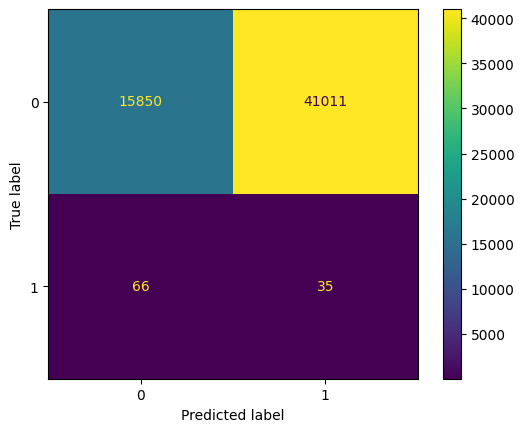

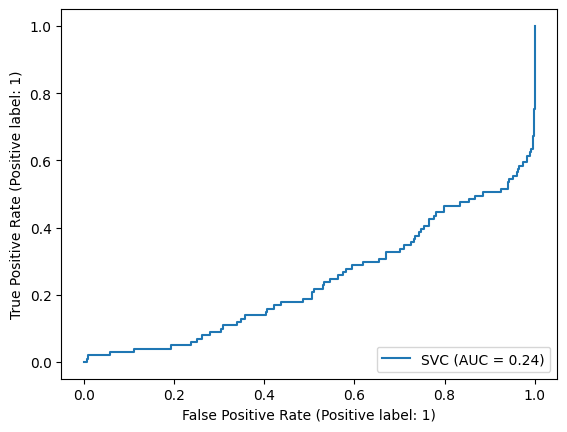

In [102]:
# This time re-do SVC rbf with same parameters except class_weight set to 'balanced'
model_name = 'SVC rbf with balanced class_weight'

params = {'C': [3.8286206358121855], 
'class_weight': ['balanced'], 
'degree': [2], 
'gamma': ['scale'], 
'max_iter': [400], 
'random_state': [0]}

model = SVC(kernel='rbf')
model_attributes = supervised(df, model, params, model_name=model_name)

best_svm_rbf2 = model_attributes.get_best_model()

In [103]:
# save the model to disk

model = best_svm_rbf2

filename = 'model_best_svm_rbf_classweight_balanced.sav'
pickle.dump(model, open(filename, 'wb'))

**Data has been scaled.**


C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\silvh\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py:301: ConvergenceWarning: Solver terminated early (max_iter=400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVC rbf with balanced class_weight evaluation metrics: 
	Test data	Training data		Difference
Recall: 	45.54%		41.18%		4.37%
Precision: 	0.14%		0.12%		0.02%
F1: 		0.27%		0.24%		0.03%
AUC: 		43.04%		40.78%		2.26%
Best model parameters from randomized search: {'random_state': 0, 'max_iter': 400, 'gamma': 'scale', 'degree': 2, 'class_weight': {0: 1, 1: 99}, 'C': 3.8286206358121855}


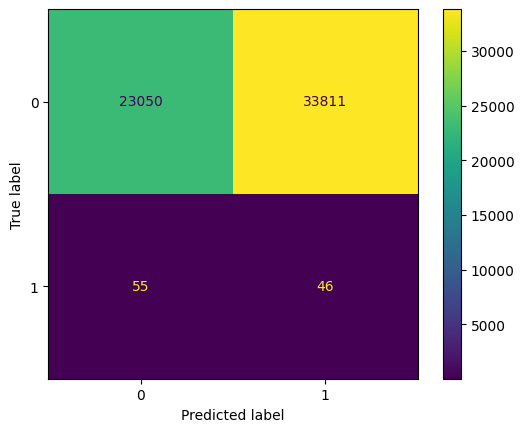

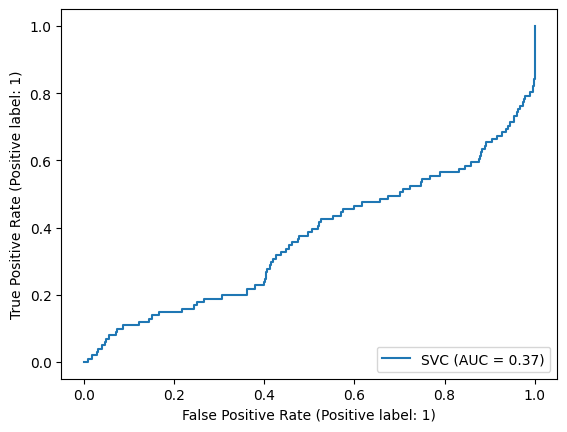

In [104]:
# This time re-do SVC rbf with same parameters except class_weight set with dictionary'
model_name = 'SVC rbf with balanced class_weight'

params = {'C': [3.8286206358121855], 
'class_weight': [{0: 1, 1: 99}], 
'degree': [2], 
'gamma': ['scale'], 
'max_iter': [400], 
'random_state': [0]}

model = SVC(kernel='rbf')
model_attributes = supervised(df, model, params, model_name=model_name)

best_svm_rbf3 = model_attributes.get_best_model()

# save the model to disk

model = best_svm_rbf3

filename = 'model_best_svm_rbf_classweight_custom.sav'
pickle.dump(model, open(filename, 'wb'))

Questions:
* How to use `.predict_proba()` to set custom thresholds